In [1]:
import matplotlib as mpl

In [2]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [184]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

In [3]:
import vehicleDetection

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
import glob

In [42]:
datadir = './data/vehicles/vehicles/GTI_MiddleClose/'
countmax = 500
paths = glob.glob(datadir + '*.png')
paths.sort()
paths = paths[:countmax]

In [43]:
images = [vehicleDetection.data.readImage(path) for path in paths]

In [156]:
detector = vehicleDetection.detector.Detector(featurizeKwargs=dict(
    spatial_feat=False, hist_feat=True, hog_feat=False,
))
featureString = 'color histogram features'

Got scalar parameter (gamma). Assuming no CV requested.


In [157]:
imageFeatures = [
    detector.featurize(image)
    for image in tqdm.tqdm_notebook(images)
]

HBox(children=(IntProgress(value=0, max=419), HTML(value='')))

In [158]:
detector.scaler.fit(np.stack(imageFeatures))

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [159]:
scaledImageFeatures = [
    detector.scaler.transform(feat.reshape((1, -1)))
    for feat in imageFeatures
]

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [160]:
distances = [
    np.linalg.norm(scaledImageFeatures[i+1] - scaledImageFeatures[i])
    for i in range(len(scaledImageFeatures) - 1)
]

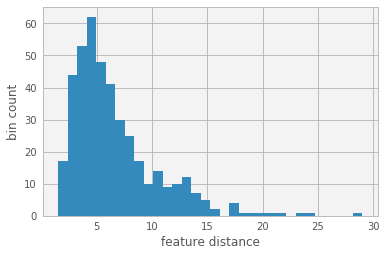

In [161]:
fig, ax = plt.subplots()
ax.hist(distances, bins=32);
ax.set_xlabel('feature distance')
ax.set_ylabel('bin count')

In [162]:
pathIndices = [
    int(os.path.basename(path).replace('image', '').replace('.png', ''))
    for path in paths
]

In [163]:
indexJumps = np.diff(pathIndices)

In [164]:
jumps = [
    i for i in range(len(indexJumps))
    if indexJumps[i] > 1
]

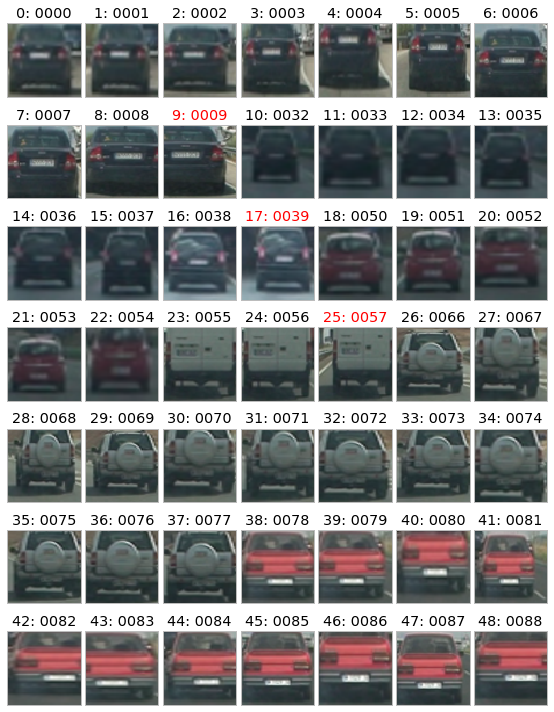

In [165]:
import os

fig, axes = plt.subplots(nrows=7, ncols=7, figsize=(8, 10))
axes = axes.ravel()
j
for i in range(len(axes)):
    ax = axes[i]
    #i += 2*len(axes)
    img = images[i]
    path = paths[i]
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(
        '%d: %s' % (
            i, os.path.basename(path).replace('.png', '').replace('image', '')
        ),
        color='red' if indexJumps[i] > 1 else 'black'
    )
fig.tight_layout()
fig.subplots_adjust(wspace=.0)
fig.savefig('doc/sortedGTICarImages.png')

In [166]:
manualJumps = [
    9, 17, 22, 25, 37, 48, 59, 69, 78, 79, 80, 81, 85, 95, 105, 110, 120, 130, 140, 145
]

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


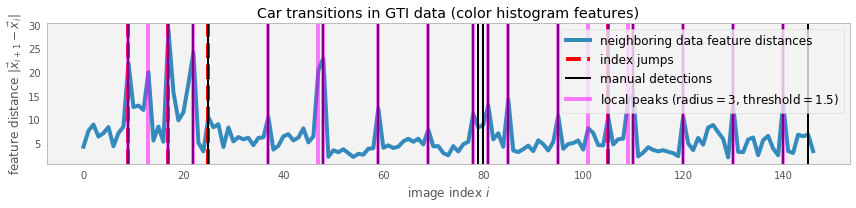

In [200]:
fig, ax = plt.subplots(figsize=(12, 3))
x = range(max(manualJumps)+2)
# x = range(len(axes))
ax.plot(x, [distances[i] for i in x], label='neighboring data feature distances')
# ax.set_xticks(x)
for jps in jumps, manualJumps:
    for j in jps:
        if j in x:
            ax.axvline(
                j, 
                color='black' if jps is manualJumps else 'red',
                linestyle='-' if jps is manualJumps else '--',
                linewidth=2 if  jps is manualJumps else 4,
                label=(
                    ('manual detections' if jps is manualJumps else 'index jumps')
                    if j == jps[0] else None
                )
            )

# Find peaks by neighborhood.
radius = 3
threshold = 1.5
label = r'local peaks (radius$=%d$, threshold$=%.1f$)' % (radius, threshold)
for i in range(len(distances)):
    lo = max(0, i - radius)
    hi = min(len(distances) - 1, i + radius)
    if distances[i] / np.median(distances[lo:hi]) > threshold and i in x:
        ax.axvline(
            i, color='magenta', label=label, linewidth=4, alpha=.5
        )
        label = None

ax.legend(fontsize=12)
# ax.set_xlim(20, 30)
ax.grid(False)
ax.set_xlabel('image index $i$')
ax.set_ylabel(r'feature distance $|\vec x_{i+1} - \vec x_i|$');
ax.set_title('Car transitions in GTI data (%s)' % featureString)
fig.savefig('doc/carTransitions.png')

/home/tsbertalan/.virtualenvs/carnd/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


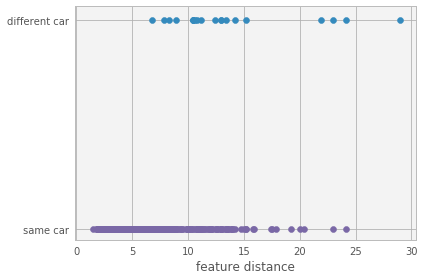

In [186]:
jumpDistances = [distances[j] for j in manualJumps]
nonjumpDistances = [distances[j] for j in range(len(distances)) if j not in jumps]

fig, ax = plt.subplots()
ax.scatter(jumpDistances, [1]*len(jumpDistances))
ax.scatter(nonjumpDistances, [0]*len(nonjumpDistances))
ax.set_yticks([False, True])
ax.set_yticklabels(['same car', 'different car'])
ax.set_xlabel('feature distance')
fig.savefig('doc/logisticRegressionHard.png')
# fig.subplots_adjust(left=.5)